In [51]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') )
from jerks import jerks
import chaosmagpy as cp

# %%
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'):
    os.system('wget --no-verbose http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat')

# %%
# import the dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

# %%
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

# %%
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]
"""
# %%
"""


radius = 6371.
theta = 90
phi = 30
jerk_number = 8 # in Python indexing

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


run_components=[1] 
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
CP_NBINS = 1*np.int(TIMES_MAX - TIMES_MIN) #one per year
CP_hist_save = np.zeros( (len(run_components),CP_NBINS), dtype=int )
    
time_intervals_edges = np.arange(-210,211,20) + jerk_times[jerk_number]
time_intervals_nbins = time_intervals_edges.shape[0]-1

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    K_MIN = 0
    K_MAX = 100
    sigmas = np.array([10,5,10],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    THIN = 100
    NBINS = 100
    credible = 0.0
    RUNNING_MODE = 1
    burn_in = 10000
    NSAMPLE = 2000000+burn_in
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    CP_hist_run = np.zeros( CP_NBINS, dtype=int )
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    delta_slope = np.zeros( time_intervals_nbins,dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP_hist_run, delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
         nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
         y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
         k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
         thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    CP_hist_run = CP_hist_run / ( (NSAMPLE-burn_in)/THIN )
    print(i, Acceptance_rates)
    print(delta_slope)
    
     

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]
1 [51.53440094 43.23731613  4.60928822  4.6149354 ]
[1.52588613e-01 6.86720472e-01 7.39602169e+00 9.37015536e+00
 7.23797156e-02 6.79410290e-02 2.06963078e+00 2.14003909e+00
 4.07599862e-01 1.15740919e+00 6.84273807e+01 2.54780633e+00
 3.72800727e-01 7.69028703e+00 2.71013090e-01 7.01440021e+00
 2.32855876e-01 1.96852585e+00 4.00575393e-01 1.74909264e+00
 2.55573118e+00]


<Figure size 432x288 with 0 Axes>

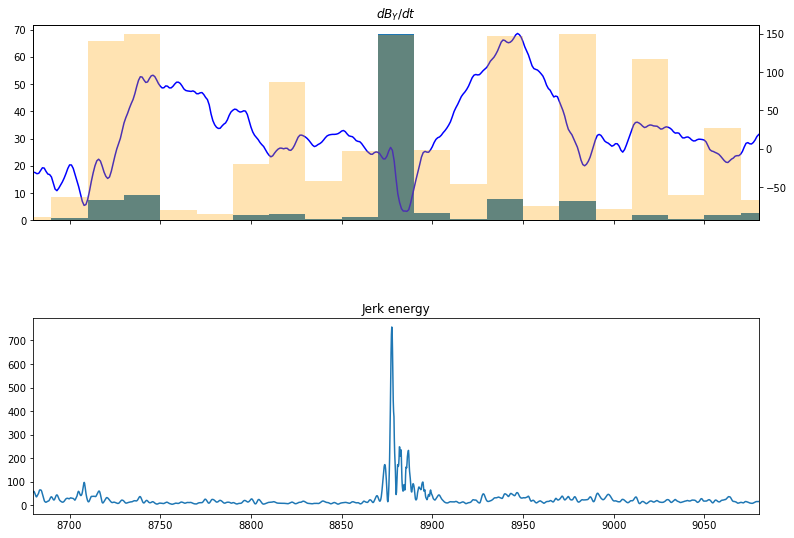

In [45]:
plt.figure()
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(13,9), sharex=True)

delta = delta_slope
CP = CP_hist_run


Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
left_edges = time_intervals_edges[0:time_intervals_nbins]


ax1.bar(left_edges, delta, align='edge', width=time_intervals_edges[1:] - time_intervals_edges[0:time_intervals_nbins])
ax1.set_xlim(time_yearly.min(), time_yearly.max() )
ax5 = ax1.twinx()

ax5.plot(TIMES,SV,'b')

ax3 = ax1.twinx()


ax1.set_title(r'$d{B_Y}/dt$')
ax3.bar(left_edges, CP, align='edge', width = 1*(left_edges[1] - left_edges[0]),color='orange',alpha=0.3)
ax3.yaxis.set_visible(False) 

time_EJ, EJ = np.loadtxt('../Jerk_energy.dat',unpack=True)
ax2.plot(time_EJ, EJ )

ax2.set_xlim(time_yearly.min(), time_yearly.max()  )
ax2.set_title('Jerk energy')


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


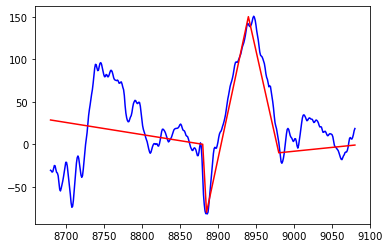

In [46]:
plt.figure()
plt.plot(TIMES,SV,'b')
test_series = np.interp(time_yearly,[8600,8880,8885,8940,8980,9200],
                        [40,0,-80,150,-10,10])
plt.plot(TIMES,test_series,'r')

In [47]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') )
from jerks import jerks
import chaosmagpy as cp

# %%
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'):
    os.system('wget --no-verbose http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat')

# %%
# import the dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

# %%
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

# %%
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]
"""
# %%
"""


radius = 6371.
theta = 90
phi = 30
jerk_number = 8 # in Python indexing

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


run_components=[1] 
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
CP_NBINS = 1*np.int(TIMES_MAX - TIMES_MIN) #one per year
CP_hist_save = np.zeros( (len(run_components),CP_NBINS), dtype=int )
    
time_intervals_edges = np.arange(-210,211,20) + jerk_times[jerk_number]
time_intervals_nbins = time_intervals_edges.shape[0]-1

for i in run_components:
        
    SV = test_series
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    K_MIN = 0
    K_MAX = 100
    sigmas = np.array([10,5,10],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    THIN = 100
    NBINS = 100
    credible = 0.0
    RUNNING_MODE = 1
    burn_in = 10000
    NSAMPLE = 2000000+burn_in
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    CP_hist_run = np.zeros( CP_NBINS, dtype=int )
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    delta_slope = np.zeros( time_intervals_nbins,dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP_hist_run, delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
         nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
         y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
         k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
         thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    CP_hist_run = CP_hist_run / ( (NSAMPLE-burn_in)/THIN )
    print(i, Acceptance_rates)
    
    
     

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]
1 [40.60710144 30.1776638   2.41844082  2.42140365]


<Figure size 432x288 with 0 Axes>

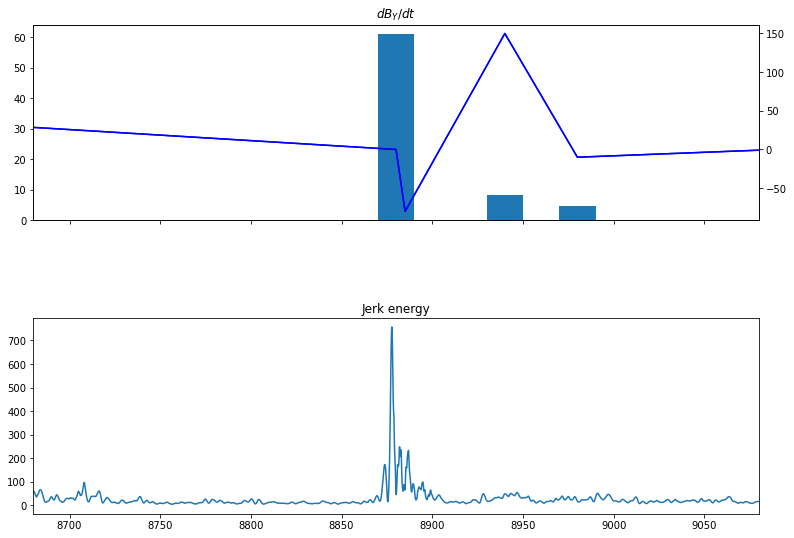

In [49]:
plt.figure()
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(13,9), sharex=True)

delta = delta_slope
CP = CP_hist_run


left_edges = time_intervals_edges[0:time_intervals_nbins]


ax1.bar(left_edges, delta, align='edge', width=time_intervals_edges[1:] - time_intervals_edges[0:time_intervals_nbins])
ax1.set_xlim(time_yearly.min(), time_yearly.max() )
ax5 = ax1.twinx()

ax5.plot(TIMES,SV,'b')
ax5.plot(TIMES,test_series,'b')

#ax3 = ax1.twinx()


ax1.set_title(r'$d{B_Y}/dt$')
#ax3.bar(left_edges, CP, align='edge', width = 1*(left_edges[1] - left_edges[0]),color='orange',alpha=0.3)


time_EJ, EJ = np.loadtxt('../Jerk_energy.dat',unpack=True)
ax2.plot(time_EJ, EJ )

ax2.set_xlim(time_yearly.min(), time_yearly.max()  )
ax2.set_title('Jerk energy')


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
